# 案例1：鸢尾花分类

In [1]:
import sys
sys.path.append(r"D:\Rhitta_GPU")
import numpy as np
import cupy as cp
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import rhitta.nn as nn
import matplotlib.pyplot as plt

### 第一步：读取数据集

In [2]:
data = pd.read_csv("../data/dataset/Iris.csv", header=0, index_col="Id")
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica


In [3]:
labelencoder = LabelEncoder()
onehotencoder = OneHotEncoder(sparse_output=False)
# 把类别编码为数字标签
number_labels = labelencoder.fit_transform(data["Species"].values)
# 再把数字标签转换为one-hot向量
labels = onehotencoder.fit_transform(number_labels.reshape(-1, 1))
# 取出前4列特征
features = data.iloc[:, 0:4].values
# 打印前3个样本
features[:3,:],labels[:3,:]

(array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]))

In [4]:
# 把需要用到的数据转换为cupy.ndarray格式
number_labels = cp.array(number_labels)
features = cp.array(features)
labels = cp.array(labels)
number_labels.shape,features.shape,labels.shape

((150,), (150, 4), (150, 3))

### 第二步：构造模型

In [5]:
initlizer = nn.Normal_initializer(0, 1)
x = nn.to_tensor(size=(1, 4))          # 存放输入
y = nn.to_tensor(size=(1, 3))          # 存放标签

W = nn.to_tensor(size=(4, 3), require_gradient=True, initializer=initlizer)
b = nn.to_tensor(size=(1, 3), require_gradient=True, initializer=initlizer)

output = x*W+b
predict = nn.Softmax(output)            # （1，3）
loss = nn.CrossEntropyLoss(output, y)   # （1，1）

### 第三步：初始化优化器

In [6]:
learning_rate = 0.01
optimizer = nn.Adam(nn.default_graph, loss, learning_rate=learning_rate)

### 开始训练、评估  

epoch:0 , accuracy:0.3333333333333333
epoch:10 , accuracy:0.88
epoch:20 , accuracy:0.9333333333333333
epoch:30 , accuracy:0.9333333333333333
epoch:40 , accuracy:0.9266666666666666
epoch:50 , accuracy:0.9266666666666666
epoch:60 , accuracy:0.9333333333333333
epoch:70 , accuracy:0.94
epoch:80 , accuracy:0.94
epoch:90 , accuracy:0.9466666666666667


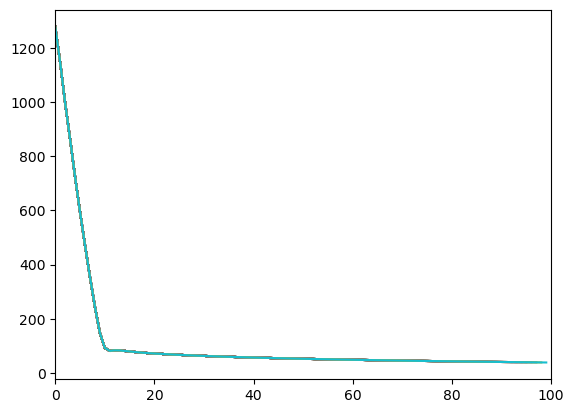

In [7]:
batch_size = 16
epochs = 100

plt.figure()
plt.subplot()
plt.axis(xmin=0,xmax=epochs)
axis_x=[]
axis_y=[]

for epoch in range(epochs):
    count = 0
    N = len(features)

    # 训练
    overall_loss=0
    for i in range(N):
        # 填坑，前向反向传播
        x.set_value(features[i, :])
        y.set_value(labels[i, :])
        optimizer.one_step()  
        # 累加样本损失
        overall_loss += loss.value
        # 更新计数器，达到batch_size后更新参数
        # 对于最后一批，数量不够16，是不能执行update的，一直到外层for循环结束
        count += 1
        if count >= batch_size:  
            optimizer.update()  
            count = 0
            
    # 绘制loss曲线
    axis_x.append(epoch)
    axis_y.append(cp.asnumpy(overall_loss))
    plt.plot(axis_x,axis_y)

    #每个epoch后评估模型的准确率
    pred = []
    for i in range(N):
        x.set_value(features[i, :])
        y.set_value(labels[i, :])
        predict.forward()
        pred.append(predict.value.flatten())           # pred.append([0.8,0.1,0.1])
    pred = cp.array(pred).argmax(axis=1)       # 每一行变成预测的类别数字
    accuracy = (number_labels == pred).sum()/N  # 全部的预测和全部的标签对比，计算准确率
    if epoch%10 == 0:
        print("epoch:{} , accuracy:{}".format(epoch,accuracy))

    
